# Forest cover type prediction in Roosevelt National Forest

# Ensemble tree algorithms

In this experiment we will apply some ensemble methods based on Decisión Trees to find out an initial good classifier for the problem. We try out some approaches like:
- Random Forest
- Decision Tree
- AdaBoosted Decision Tree
- Bagging Classifier
- Gradient Boosting
- XGBoost


### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

%matplotlib inline

Set some global variables

In [2]:
# Global parameters
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH


## Read training and test data

In [3]:
# Reading the csv file with the whole dataset
data = pd.read_csv(train_path+'\\train.csv', sep=',', header=0, index_col=0)
# Train data, erasing label column
train_data = data.drop('Cover_Type', axis=1)

train_label = data[['Cover_Type']]
#test_data = pd.read_csv('test_values.csv', sep=',', header=0,index_col=0)

## Data preprocessing

### Define global variables to use in the preprocessing stage

In [4]:
# Define some groups of columns based on  type
var_numeric = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']
# There are no categoric variables to transfomr
var_categoric = []

# Numerical columns with missing values
# In our first approach, no missing values to consider
columns_nan=[]

#Defining some relevant group of columns
# Columns to be ingored for classification
# Soil Type 7,8, 15 y 25
columns_to_ignore = ['Soil_Type7','Soil_Type8','Soil_Type15','Soil_Type25']

num_columns_nan=[i for i in columns_nan if i not in columns_to_ignore]
enconde_cols_name=[i for i in var_categoric if i not in columns_to_ignore]



### Feature engineering and selection

In [5]:
# Horizontal to roadways and to Fire poins are very simila recpect to arget variable so lets drop horizontal to roadways
# Horizontal and vertical to hidrology are correlated, lets drop vertical
# Drop soil types where the number of rows are very low: 9, 21, 27, 28, 36
# Set some more columns to ignore
columns_unselect=['Soil_Type9','Soil_Type21','Soil_Type27','Soil_Type28','Soil_Type36']


In [6]:
# Manipulate and transform columns in dataframe to be used in the next stages

# Delete non relevant columns
train_df= train_data.drop(columns_to_ignore+columns_unselect, axis=1)


#Filling na values in columns
#Not neccesary at this moment

#Dealing with ourliers or data errors
#Not neccesary at this moment

# Define columns to fill nan values and categorial columns to one-hot-encode 
columns_nan=[train_df.columns.tolist().index(i) for i in num_columns_nan]
columns_enconde=[train_df.columns.tolist().index(i) for i in enconde_cols_name]


## Preparing the data for the algorithm

In [7]:
# Tranform to numpy array
X = train_df.values
y = train_label.values.ravel()

#Convertimos todos los valores a float incluida la columna boolean
# To avoid error in the imputer action if it was neccesary
X= np.vstack(X[:, :]).astype(np.float)

print('X: ', X.shape)
print('y: ', y.shape)
#X Shape 500,000 x 8

X:  (15120, 45)
y:  (15120,)


### Filling missing values

In [7]:
# Taking care of missing data in numerical columns
from sklearn.impute import SimpleImputer
# Define an Imputer to fill the missing values with the mean value 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X[:, columns_nan])
X[:, columns_nan] = imputer.transform(X[:, columns_nan])

if np.any(np.isnan(X)):
    print('Warning: some nan values already included')
else:
    print('No nan values included')
    
print('X Shape:',X.shape)
#X shape 500,000 x 8

No nan values included
X Shape: (500000, 9)


## Enconde categorical varables

In [8]:
#Encondeing loan_purpose variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# One hot encoder to transform the categorical variables
onehotencoder = OneHotEncoder(categorical_features = columns_enconde)
X = onehotencoder.fit_transform(X).toarray()
# Show the new shape of our arrays
print('X Shape:',X.shape)
print('Categories Encoded: ',onehotencoder.categories_)
print('Features Names Encoded: ',onehotencoder.get_feature_names())
# X Shape 500,000 x 20

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


X Shape: (500000, 29)
Categories Encoded:  [array([1., 2., 3.]), array([1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7.]), array([0., 1.]), array([0., 1., 2., 3., 4., 5., 6., 7., 8.])]
Features Names Encoded:  ['x0_1.0' 'x0_2.0' 'x0_3.0' 'x1_1.0' 'x1_2.0' 'x1_3.0' 'x1_4.0' 'x2_1.0'
 'x2_2.0' 'x2_3.0' 'x2_4.0' 'x2_5.0' 'x2_6.0' 'x2_7.0' 'x3_0.0' 'x3_1.0'
 'x4_0.0' 'x4_1.0' 'x4_2.0' 'x4_3.0' 'x4_4.0' 'x4_5.0' 'x4_6.0' 'x4_7.0'
 'x4_8.0']


### Creating the train and test datasets

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)

X Train Shape: (11340, 45)
X Test Shape: (3780, 45)


## Building and training the algorithms

### Train the algorithm: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Define the classifier and the parameters
classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy',max_depth=None,min_samples_split=2,min_samples_leaf=1,
                                    max_leaf_nodes=None,random_state = 0)
# Fit or train the model
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Train the algorithm: Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
# Define the classifier and the parameters
classifier = DecisionTreeClassifier(criterion = 'entropy',max_depth=None,min_samples_split=2,min_samples_leaf=1,
                                    max_leaf_nodes=None,random_state = 0)
# Fit or train the model
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Train the algorithm: AdaBoosted Decision Tree

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Define the base estimator for the Adaboost algorithm
base_classifier = DecisionTreeClassifier(criterion ='entropy',max_depth=None, min_samples_split=2,min_samples_leaf=2,
                                                       max_leaf_nodes=None,random_state = 0)
# Define the classifier and the parameters
classifier = AdaBoostClassifier(base_estimator=base_classifier,n_estimators=100,
                                learning_rate=1,random_state=0)
# Fit or train the model
classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1, n_estimators=100, random_state=0)

### Train the algorithm: Bagging Classifier

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the base estimator for the Adaboost algorithm
parameter_candidates = [{'n_estimators': [150, 300, 700], 'max_samples': [0.5,0.75,1.0], 'max_features':[0.5,0.75,1.0]}]

base_classifier = DecisionTreeClassifier(criterion ='entropy',max_depth=None, min_samples_split=2, min_samples_leaf=2,
                                                       max_leaf_nodes=None, random_state = 0)
# Use a Grid Search corss-validation strategy to model the bagging classifier
classifier = GridSearchCV(estimator=BaggingClassifier(base_estimator=base_classifier, random_state=0, n_jobs=-1, verbose=0),
                          param_grid=parameter_candidates, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

#classifier = BaggingClassifier(base_estimator=base_classifier,n_estimators=150,random_state=0, n_jobs=-1, verbose=0)

# Fit or train the model
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 23.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='entropy',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=2,
                                                                               min_samples_split=2,
                                                

### Train the algorithm: Gradient Boosting Classifier

In [30]:
# Fitting Decision Tree to the Training set
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.tree import DecisionTreeClassifier
#classifier = GradientBoostingClassifier(n_estimators=100,learning_rate=0.5,max_depth=15,
#              min_samples_leaf=1, min_samples_split=2,random_state=0,verbose=1)

#Hyperparameter tuning with Grid Search Cross validation strategy
parameter_candidates = [{'n_estimators': [50, 100, 125], 'learning_rate': [0.5,0.2,0.1], 'max_depth':[5,10,None]}]

# Define the classifier
classifier = GridSearchCV(estimator=GradientBoostingClassifier(min_samples_leaf=1, min_samples_split=2,random_state=0,verbose=1),
                          param_grid=parameter_candidates, n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# Fit or train the model
classifier.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 32.9min finished


      Iter       Train Loss   Remaining Time 
         1       17279.5751            1.87m
         2       14352.0502            1.92m
         3       12216.9954            1.95m
         4       10571.5345            1.96m
         5        9259.0542            1.95m
         6        8139.1295            1.94m
         7        7205.7734            1.92m
         8        6397.7392            1.91m
         9        5714.8294            1.90m
        10        5122.8614            1.90m
        20        1990.4611            1.85m
        30         972.4798            1.69m
        40         562.8654            1.48m
        50         346.3773            1.28m
        60         225.3424            1.08m
        70         146.6349           53.41s
        80          96.2228           42.37s
        90          64.9534           32.17s
       100          45.4230           22.38s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 125], 'learning_rate': [0.5, 0.2, 0.1], 'max_depth': [5, 10, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

## Show the estimators and score results

In [18]:
#Show the results of the hyperparameter tunning
print(classifier.best_params_)
print(classifier.best_estimator_)

{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 300}
BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=0,
              

In [19]:
# Scoring the model by Cross Validation
from sklearn.model_selection import cross_val_score
# Get the accuracies from the cross validation strategy
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
# Calculate the mean and standard deviation of the accuracies
mean_score = accuracies.mean()
std_score = accuracies.std()
print('Mean: ',mean_score)
print('Std: ',std_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
C:\Users\edumu\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 20.2min finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
C:\Users\edumu\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 19.6min finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
C:\Users\edumu\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 18.1min finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
C:\Users\edumu\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 17.5min finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 16.0min finished


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\edumu\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

## Scoring and evaluating the model

In [13]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ',cm)

acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)


Confusion Matrix:  [[403  91   2   0   8   5  36]
 [ 98 344  16   0  47  12   8]
 [  0   3 452  33   9  54   0]
 [  0   0  11 524   0   9   0]
 [  2  18  12   0 489   4   0]
 [  0   5  65   9  12 468   0]
 [ 24   1   0   0   0   0 506]]
Accuracy:  0.8428571428571429


## Showing the results

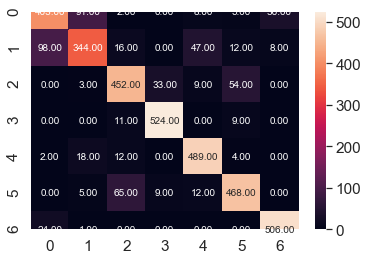

In [14]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='.2f',annot_kws={"size": 10})# font size

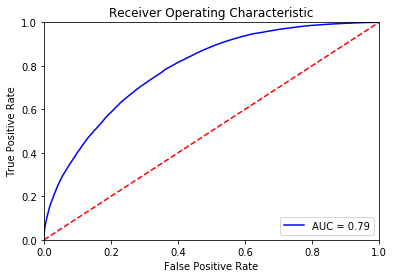

In [14]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Building and training a XGBoosted Classifier

We will pay atention to one of the best approaches to an ensemble of trees: the XGBoost model.

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### Simple train and score 

In [15]:
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.87%


### Use early stopping to prevent overfiting

In [17]:
# fit model on training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-mlogloss:1.81184
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.70536
[2]	validation_0-mlogloss:1.60817
[3]	validation_0-mlogloss:1.52564
[4]	validation_0-mlogloss:1.45405
[5]	validation_0-mlogloss:1.39166
[6]	validation_0-mlogloss:1.33615
[7]	validation_0-mlogloss:1.28701
[8]	validation_0-mlogloss:1.24252
[9]	validation_0-mlogloss:1.20185
[10]	validation_0-mlogloss:1.16566
[11]	validation_0-mlogloss:1.13161
[12]	validation_0-mlogloss:1.10187
[13]	validation_0-mlogloss:1.07309
[14]	validation_0-mlogloss:1.04709
[15]	validation_0-mlogloss:1.02314
[16]	validation_0-mlogloss:1.00087
[17]	validation_0-mlogloss:0.979585
[18]	validation_0-mlogloss:0.961162
[19]	validation_0-mlogloss:0.944345
[20]	validation_0-mlogloss:0.927887
[21]	validation_0-mlogloss:0.912448
[22]	validation_0-mlogloss:0.897978
[23]	validation_0-mlogloss:0.884746
[24]	validation_0-mlogloss:0.872194
[25]	validation_0-mlogloss:0.86135
[26]	validation_0-mlogl

In [18]:
print(model.feature_importances_)

[0.11665306 0.00693619 0.00625086 0.02033894 0.01081294 0.01420751
 0.02833169 0.01276159 0.00985048 0.01355531 0.02229558 0.00711938
 0.0211423  0.0933722  0.0066583  0.01004208 0.05041707 0.02392996
 0.01250993 0.01098667 0.         0.04807513 0.00604195 0.0339755
 0.02577008 0.00442801 0.00190394 0.01292626 0.         0.
 0.00368925 0.         0.02352204 0.01841108 0.00862217 0.
 0.         0.         0.02629612 0.19710079 0.00738642 0.01835677
 0.01105236 0.00128078 0.00456985 0.         0.         0.01546755
 0.02246774 0.01048422]


<Figure size 720x1440 with 0 Axes>

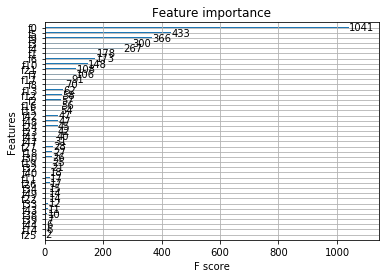

In [23]:
from xgboost import plot_importance
plt.figure(figsize=(10,20))
plot_importance(model)
plt.show()

### Hyperparameter tunning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()

n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 31.3min finished


In [27]:
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.368889 using {'max_depth': 8, 'n_estimators': 200}
-0.792418 (0.019440) with: {'max_depth': 2, 'n_estimators': 50}
-0.682119 (0.021245) with: {'max_depth': 2, 'n_estimators': 100}
-0.633146 (0.021427) with: {'max_depth': 2, 'n_estimators': 150}
-0.602118 (0.021040) with: {'max_depth': 2, 'n_estimators': 200}
-0.642494 (0.020331) with: {'max_depth': 4, 'n_estimators': 50}
-0.543494 (0.020418) with: {'max_depth': 4, 'n_estimators': 100}
-0.495503 (0.019557) with: {'max_depth': 4, 'n_estimators': 150}
-0.468006 (0.020418) with: {'max_depth': 4, 'n_estimators': 200}
-0.539366 (0.019385) with: {'max_depth': 6, 'n_estimators': 50}
-0.454329 (0.020631) with: {'max_depth': 6, 'n_estimators': 100}
-0.417578 (0.024626) with: {'max_depth': 6, 'n_estimators': 150}
-0.397278 (0.024947) with: {'max_depth': 6, 'n_estimators': 200}
-0.473768 (0.020015) with: {'max_depth': 8, 'n_estimators': 50}
-0.402162 (0.022094) with: {'max_depth': 8, 'n_estimators': 100}
-0.378367 (0.025373) with: {'max_d